In [1]:
import sys
# !{sys.executable} -m pip install haystack-ai
# !{sys.executable} -m pip install elasticsearch-haystack 
# !{sys.executable} -m pip elasticsearch-haystack
# !{sys.executable} -m pip install huggingface_hub
# !{sys.executable} -m pip  install "huggingface_hub>=0.27.0"

In [2]:
import os
from haystack import Pipeline
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchBM25Retriever
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import HuggingFaceAPIGenerator
from haystack.components.converters import TextFileToDocument
from haystack.components.writers import DocumentWriter
from haystack.components.preprocessors import DocumentSplitter
from haystack.utils import Secret
from elasticsearch import Elasticsearch, NotFoundError
import huggingface_hub

In [3]:
!rm -rf transcripts/
!wget https://github.com/CS639-Data-Management-for-Data-Science/s25/raw/main/p6/transcripts.zip
!unzip transcripts.zip -d transcripts/

--2025-05-08 06:39:17--  https://github.com/CS639-Data-Management-for-Data-Science/s25/raw/main/p6/transcripts.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CS639-Data-Management-for-Data-Science/s25/main/p6/transcripts.zip [following]
--2025-05-08 06:39:17--  https://raw.githubusercontent.com/CS639-Data-Management-for-Data-Science/s25/main/p6/transcripts.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
200 OKequest sent, awaiting response... 
Length: 290933 (284K) [application/zip]
Saving to: ‘transcripts.zip.28’

transcripts.zip.28  100%[===================>] 284.11K  --.-KB/s    in 0.03s   

2025-05-08 06:39:17 (8.72 MB/s) - ‘transcripts

In [4]:
# Define index name
index_name = "lecture_transcripts"

# Create raw Elasticsearch client to manage indices directly
client = Elasticsearch("http://localhost:9200", basic_auth=("elastic", "sD5F3szZ"))

# Delete index if it exists
try:
    client.indices.delete(index=index_name)
    print(f"Deleted existing index '{index_name}'")
except NotFoundError:
    print("Index doesn't exist!")

# Create index (optional — can skip if using Haystack's DocumentStore)
client.indices.create(index=index_name)

# Now create the Haystack-compatible document store
document_store = ElasticsearchDocumentStore(
    hosts="http://localhost:9200",
    basic_auth=("elastic", "sD5F3szZ"),
    index=index_name
)

Deleted existing index 'lecture_transcripts'


In [5]:
document_store

In [6]:
index_pipeline = Pipeline()
index_pipeline.add_component("converter", TextFileToDocument())
index_pipeline.add_component("splitter", DocumentSplitter(split_by="word", split_length=150))
index_pipeline.add_component("writer", DocumentWriter(document_store))
index_pipeline.connect("converter", "splitter")
index_pipeline.connect("splitter", "writer")


🚅 Components
  - converter: TextFileToDocument
  - splitter: DocumentSplitter
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> writer.documents (List[Document])

In [7]:
import glob

text_files = glob.glob("transcripts/transcripts/*.txt")

index_pipeline.run({"converter": {"sources": text_files}})

{'writer': {'documents_written': 901}}

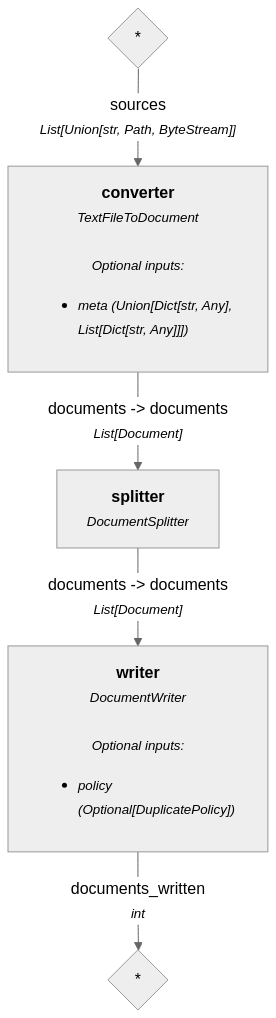

In [8]:
index_pipeline.show()

In [9]:
template = """
<|system|>
You are a helpful assistant.<|end|>
<|user|>
Given the following information, answer the question.

Context: 
{% for document in documents %}
  {{ document.content }}
{% endfor %}

Question: {{ query }}?<|end|>
<|assistant|>"""

In [14]:
%reset -f

In [15]:
%%writefile app.py
import streamlit as st
from haystack import Pipeline
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchBM25Retriever
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import HuggingFaceAPIGenerator
from haystack.components.converters import TextFileToDocument
from haystack.components.writers import DocumentWriter
from haystack.components.preprocessors import DocumentSplitter
from haystack.utils import Secret
from elasticsearch import Elasticsearch, NotFoundError
import huggingface_hub
from huggingface_hub import login

template = """
<|system|>
You are a helpful assistant.<|end|>
<|user|>
Given the following information, answer the question.

Context: 
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ query }}?<|end|>
<|assistant|>
"""

# Insert login token for HuggingFace API

from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore

index_name = "lecture_transcripts"

client = Elasticsearch("http://localhost:9200", basic_auth=("elastic", "sD5F3szZ"))

try:
    client.indices.delete(index=index_name)
except NotFoundError:
    print("Index doesn't exist!")

client.indices.create(index=index_name)

document_store = ElasticsearchDocumentStore(
    hosts="http://localhost:9200",
    basic_auth=("elastic", "sD5F3szZ"),
    index=index_name
)

document_store = ElasticsearchDocumentStore(hosts="http://localhost:9200", basic_auth=("elastic", "sD5F3szZ"), index=index_name)

index_pipeline = Pipeline()
index_pipeline.add_component("converter", TextFileToDocument())
index_pipeline.add_component("splitter", DocumentSplitter(split_by="word", split_length=150))
index_pipeline.add_component("writer", DocumentWriter(document_store))
index_pipeline.connect("converter", "splitter")
index_pipeline.connect("splitter", "writer")

import glob

text_files = glob.glob("transcripts/transcripts/*.txt")

index_pipeline.run({"converter": {"sources": text_files}})

retriever = ElasticsearchBM25Retriever(document_store=document_store)
generator = HuggingFaceAPIGenerator(
    api_type="serverless_inference_api",
    api_params={
        "model": "google/flan-t5-base", 
        "max_new_tokens": 200
    }
)

rag_pipeline = Pipeline()
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipeline.add_component("llm", generator)
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

st.title("💬 Course Chatbot")
st.caption("🚀 Interactive Q&A with Elasticsearch, Haystack, and HuggingFace")

if "messages" not in st.session_state:
    st.session_state.messages = []

for msg in st.session_state.messages:
    st.chat_message(msg["role"]).write(msg["content"])

if prompt := st.chat_input("Ask a question about the course transcripts"):
    st.session_state.messages.append({"role": "user", "content": prompt})
    st.chat_message("user").write(prompt)

    response = rag_pipeline.run({
        "prompt_builder": {"query": prompt},
        "retriever": {"query": prompt}
    })['llm']['replies'][0]

    st.session_state.messages.append({"role": "assistant", "content": response})
    st.chat_message("assistant").write(response)


Overwriting app.py


In [16]:
!curl https://loca.lt/mytunnelpassword

34.69.165.207

In [17]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.128.0.3:8501
  External URL: http://34.69.165.207:8501

your url is: https://two-items-wear.loca.lt
PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
/home/purandhar/miniconda3/lib/python3.12/site-packages/huggingface_hub/inference/_client.py:2234: FutureWarning: `stop_sequences` is a depreca